In [11]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math


In [12]:
data_directory = "../data/curated/"
merchants = pd.read_parquet(data_directory + "merchants.parquet")
transactions = pd.read_parquet(data_directory + "transactions.parquet")
consumers = pd.read_parquet(data_directory + "consumers.parquet")
census = pd.read_csv(data_directory + "census.csv")

# spark = (SparkSession.builder.appName("MAST30034 Ass2 Preprocess")
#     .config("spark.sql.parquet.cacheMetadata", "true")
#     .config("spark.sql.session.timeZone", "Etc/UTC")
#     .config('spark.executor.memory', '8g')
#     .config("spark.sql.execution.arrow.pyspark.enabled", "true")
#     .config("spark.sql.repl.eagerEval.enabled", True) 
#     .getOrCreate()
# )

# pd.set_option('compute.ops_on_diff_frames', True)

In [13]:
census.head()

,postcode,Median_tot_hhd_inc_weekly,nill_income_percent_F,nill_income_percent_M,Median_age_persons,high_income_proportion,Median_mortgage_repay_monthly,house_repay_to_income
0,2000,2225.0,0.109385,0.072277,32.0,0.183133,2800.0,0.290406
1,2007,1805.0,0.130626,0.096731,30.0,0.122807,2500.0,0.319625
2,2008,1746.0,0.158961,0.126999,28.0,0.156635,2600.0,0.343643
3,2009,2422.0,0.082974,0.047567,37.0,0.251541,2800.0,0.266785
4,2010,2297.0,0.043674,0.031714,36.0,0.299588,2900.0,0.291350


In [14]:
merchants.head()

,name,tags,sector_tags,revenue_band,take_rate
merchant_abn,,,,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.33


In [15]:
user_counts = transactions.merge(merchants.reset_index()).groupby(["merchant_abn", "user_id"]).agg(count=("order_id", "count")).reset_index()

In [16]:
user_counts

,merchant_abn,user_id,count
0,10023283211,8,2
1,10023283211,15,1
2,10023283211,19,1
3,10023283211,22,1
4,10023283211,31,1
...,...,...,...
7831515,99990536339,21308,1
7831516,99990536339,21352,1
7831517,99990536339,23299,1
7831518,99990536339,23730,1


In [17]:
#Total number of customers returning
len(user_counts[user_counts["count"] > 1])/len(user_counts)

0.2687643011829121

In [18]:
pd.options.mode.chained_assignment = None

# TODO: make more efficient using groupby-apply?
# retention = (Customers End - Customers New) / Customers Start
def customer_retention(merchant_abn, transactions, month_period):
    def month_diff(d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
    
    def new_customers(aggregated, period):
        new = aggregated[aggregated["date_segment"] == period]["user_id"]
        old = aggregated[aggregated["date_segment"] == period + 1]["user_id"]
        
        return len(set(new) - set(old))
        
    # filter for specific merchant
    transactions = transactions.loc[transactions["merchant_abn"] == merchant_abn]
    
    if len(transactions) == 0:
        return []
    
    latest_date = max(transactions["order_datetime"])
    transactions["date_segment"] = transactions["order_datetime"].apply(lambda x: month_diff(latest_date, x) // month_period)
    max_segment = max(transactions["date_segment"])
    
    # aggregate by customer-timescale for specific merchant to get customers active within the timeframes
    aggregate_by = ["user_id", "date_segment"]
    aggregated_transactions = transactions.groupby(aggregate_by).count().add_suffix('_Count').reset_index()[aggregate_by]
    
    n_cust = lambda x: len(aggregated_transactions[aggregated_transactions["date_segment"] == x])

    retentions = [0 if n_cust(i+1) == 0 else (n_cust(i) - new_customers(aggregated_transactions, i))/n_cust(i+1) for i in range(0, max_segment - 1)]
    
    return retentions

In [45]:
retention = merchants.reset_index()
transactions["order_datetime"] = pd.to_datetime(transactions["order_datetime"])
retention["retention"] = retention["merchant_abn"].apply(lambda x: np.mean(customer_retention(x, transactions, 6) or [0]))
retention = retention.sort_values("retention", ascending=False)
retention


,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention
680,24852446429,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...","florists supplies, nursery stock, and flowers",c,2.94,0.974489
3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.969028
2439,64203420245,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",tent and awning shops,c,2.86,0.966885
1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959643
1694,46804135891,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...","opticians, optical goods, and eyeglasses",c,2.93,0.944943
...,...,...,...,...,...,...,...
813,27518736748,Enim LLP,"((art dealers and galleries), (c), (take rate:...",art dealers and galleries,c,2.85,0.000000
2407,63549078265,Tempus Institute,"([artist supply and craft shops], [a], [take r...",artist supply and craft shops,a,6.01,0.000000
2405,63491526748,Neque Non Company,"[(computer progRamming , data processing, and ...","computer programming , data processing, and in...",a,6.74,0.000000
814,27529271582,Pharetra Ltd,"([hobby, toy and game shops], [b], [take rate...","hobby, toy and game shops",b,4.70,0.000000


In [20]:
import seaborn as sns
# sns.kdeplot(retention["retention"])

In [21]:
transactions.head()

,user_id,merchant_abn,dollar_value,order_id,order_datetime
index,,,,,
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28


Momemtum calculations are SMA(n) - SMA(n-1)

In [111]:

transactions["month"] = pd.DatetimeIndex(transactions['order_datetime']).year * 12 + pd.DatetimeIndex(transactions['order_datetime']).month
transaction_momentum = transactions.groupby(["merchant_abn", "month"]).agg(monthly_revenue=("dollar_value", sum)).reset_index()
transactions_groupby = transaction_momentum.groupby("merchant_abn")


sma_periods = [6, 12]
col_names = [f"{sma_period}-month-sma" for sma_period in sma_periods]
diff_col_names = [f"{sma_period}-month-sma-diff" for sma_period in sma_periods]




for i, sma_period in enumerate(sma_periods):
    transaction_momentum[col_names[i]] = transactions_groupby.rolling(window=sma_period, on="month").mean().reset_index(drop=True).fillna(0)["monthly_revenue"]
    transaction_momentum[col_names[i] + "-shifted"] = transaction_momentum[col_names[i]].shift(1)
    
transaction_momentum[diff_col_names] = transaction_momentum.sort_values(["merchant_abn", "month"]).groupby("merchant_abn").diff().fillna(0)[col_names]



In [124]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

revenue_and_momentum = transaction_momentum.groupby("merchant_abn").last().reset_index()
# *6 to get back roc from SMA
revenue_and_momentum["momentum_roc"] = (((revenue_and_momentum["6-month-sma-diff"]/revenue_and_momentum["6-month-sma-shifted"]) * 24)).replace([np.inf, -np.inf, np.nan], 0)
revenue_and_momentum["momentum_score"] = sigmoid(revenue_and_momentum["momentum_roc"]).fillna(0)

revenue_and_momentum = revenue_and_momentum.merge(merchants.reset_index()[["merchant_abn", "take_rate"]], how="inner", on="merchant_abn")
revenue_and_momentum["adj_revenue"] = revenue_and_momentum["12-month-sma"] * pd.to_numeric(revenue_and_momentum["take_rate"])
revenue_and_momentum["revenue_score"] = revenue_and_momentum["adj_revenue"]/ max(revenue_and_momentum["adj_revenue"])

revenue_and_momentum.sort_values("revenue_score", ascending=False).head(15)


,merchant_abn,month,monthly_revenue,6-month-sma,6-month-sma-shifted,12-month-sma,12-month-sma-shifted,6-month-sma-diff,12-month-sma-diff,momentum_roc,momentum_score,take_rate,adj_revenue,revenue_score
1032,32361057556,24274,454143.279362,480415.502798,471068.312179,460544.205899,459581.823726,9347.190619,962.382174,0.476221,0.616855,6.61,3.044197e+06,1.000000
2441,64403598239,24274,462992.310866,482258.735008,474004.873903,465884.415486,466106.735951,8253.861105,-222.320465,0.417913,0.602984,6.31,2.939731e+06,0.965683
3437,86578477987,24274,434439.759777,468359.044492,462105.064645,450763.718392,450466.333792,6253.979847,297.384599,0.324808,0.580496,6.43,2.898411e+06,0.952110
3874,96680767841,24274,435478.836000,478286.251126,473145.271489,462259.660451,463118.760080,5140.979637,-859.099629,0.260773,0.564826,5.91,2.731955e+06,0.897430
518,21439773999,24274,445292.493005,463213.969099,455840.602093,446290.489241,445757.246689,7373.367006,533.242553,0.388208,0.595851,6.10,2.722372e+06,0.894282
3148,79827781481,24274,387068.840240,407828.387405,404100.724589,390470.962878,390620.626505,3727.662816,-149.663627,0.221390,0.555123,6.82,2.663012e+06,0.874783
1798,49322182190,24274,406760.569490,429336.127104,423715.989537,413452.673986,412134.113519,5620.137567,1318.560467,0.318334,0.578918,6.35,2.625424e+06,0.862436
3584,89726005175,24274,435465.787205,453323.170285,444736.752269,436274.056441,434934.368790,8586.418016,1339.687650,0.463362,0.613811,6.01,2.622007e+06,0.861313
1327,38700038932,24274,354892.866588,418358.578920,422076.156423,414163.744067,417161.123896,-3717.577503,-2997.379829,-0.211388,0.447349,6.31,2.613373e+06,0.858477
1762,48534649627,24274,395395.436578,407643.227300,399906.707752,393382.814722,392735.812582,7736.519547,647.002140,0.464299,0.614034,6.64,2.612062e+06,0.858046


Next up, a transaction volume/total revenue model. We assume that the distribution of transaction amount remains relatively constant over time for each merchant for this model.

In [25]:

counts = transactions.groupby(["merchant_abn", "order_datetime"]).agg(count=("dollar_value", "count")).reset_index().groupby("merchant_abn").agg(volume_mean=("count", "mean"), volume_stdev=("count", "std"))
counts = pd.concat([counts, transactions.groupby(["merchant_abn"]).agg(amount_mean=("dollar_value", "mean"), amount_stdev=("dollar_value", "std"))], axis=1).reset_index()
counts

,merchant_abn,volume_mean,volume_stdev,amount_mean,amount_stdev
0,10023283211,5.173841,2.470639,203.699989,118.653986
1,10142254217,4.808725,2.414311,33.225531,28.092970
2,10165489824,1.000000,0.000000,10165.769713,7614.022162
3,10187291046,1.337500,0.664908,109.499563,68.127948
4,10192359162,1.335907,0.621875,392.792594,254.762034
...,...,...,...,...,...
4014,99938978285,27.191419,8.010509,25.251700,21.211397
4015,99974311662,1.111111,0.370232,266.884715,179.461217
4016,99976658299,36.793729,9.875859,142.138020,74.657286
4017,99987905597,1.190476,0.473016,320.473693,148.796916


Here's what we've got to rank people now. The coefficients were somewhat arbitrarily decided such that they had a sufficient effect on the ranking, they should be tuned. We need to introduce some more features as well.

In [26]:
merchant_groupings = {
    "tent and awning shops": "Miscellaneous Stores",
    "gift, card, novelty, and souvenir shops": "Miscellaneous Stores",
    "digital goods: books, movies, music": "Miscellaneous Stores",
    "watch, clock, and jewelry repair shops": "Miscellaneous Stores",
    "cable, satellite, and other pay television and radio services": "Utility services",
    "florists supplies, nursery stock, and flowers": "Retail outlet services",
    "opticians, optical goods, and eyeglasses": "Professional services and membership organisations",
    "computers, computer peripheral equipment, and software": "Retail outlet services",
    "computer programming , data processing, and integrated systems design services": "Business Services",
    "furniture, home furnishings and equipment shops, and manufacturers, except appliances": "Miscellaneous Stores",
    "artist supply and craft shops": "Miscellaneous Stores",
    "shoe shops": "Retail outlet services",
    "books, periodicals, and newspapers": "Retail outlet services",
    "lawn and garden supply outlets, including nurseries": "Retail outlet services",
    "music shops - musical instruments, pianos, and sheet music": "Miscellaneous Stores",
    "motor vehicle supplies and new parts": "Retail outlet services",
    "health and beauty spas": "Miscellaneous Stores",
    "hobby, toy and game shops": "Miscellaneous Stores",
    "bicycle shops - sales and service": "Miscellaneous Stores",
    "antique shops - sales, repairs, and restoration services": "Miscellaneous Stores",
    "stationery, office supplies and printing and writing paper": "Retail outlet services",
    "equipment, tool, furniture, and appliance rent al and leasing": "Business Services",
    "telecom": "Utility services",
    "art dealers and galleries": "Miscellaneous Stores",
    "jewelry, watch, clock, and silverware shops": "Miscellaneous Stores"
}

Census data

In [27]:
# sns.kdeplot(census_consumers["nill_income_percent"])

/home/saurabhjhanjee/anaconda3/envs/ADS-BNPL/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='nill_income_percent_M'>

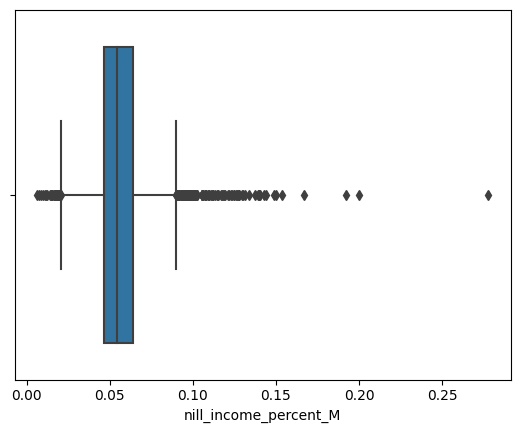

In [28]:
sns.boxplot(census["nill_income_percent_M"])

In [29]:
Q3 = np.quantile(census["nill_income_percent_M"], 0.75)
Q1 = np.quantile(census["nill_income_percent_M"], 0.25)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
upper_limit



0.0899298044316664

In [30]:
Q3 = np.quantile(census["nill_income_percent_F"], 0.75)
Q1 = np.quantile(census["nill_income_percent_F"], 0.25)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
upper_limit


0.1271447539479093

Hence we will clamp these values to 0.15 and scale them back up

In [31]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


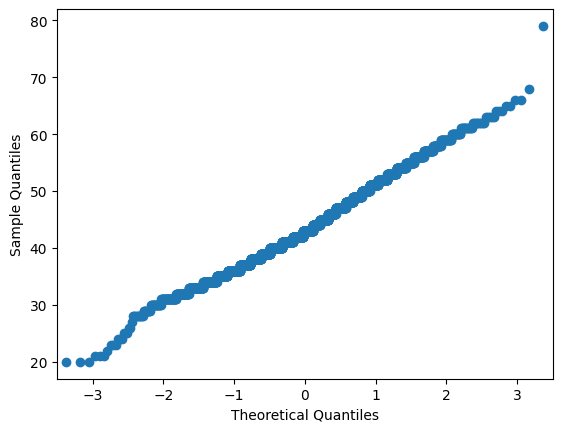

In [32]:
sm.qqplot(census["Median_age_persons"])
plt.show()


Looks kinda normal, so we standardise

In [33]:
census["Median_age_persons"] = (census["Median_age_persons"] - census["Median_age_persons"].mean() ) / census["Median_age_persons"].std()
mean = census["Median_age_persons"].mean()


census_consumers = consumers.merge(census)

def get_gender_nill_income(x):
    return {"Undisclosed":  0.5 * (x["nill_income_percent_M"] + x["nill_income_percent_F"]), "Female": x["nill_income_percent_F"], "Male": x["nill_income_percent_M"]}[x["gender"]]
census_consumers["nill_income_percent"] = census_consumers[["gender", "nill_income_percent_M", "nill_income_percent_F"]].apply(get_gender_nill_income, axis=1)

census_consumers = census_consumers[["house_repay_to_income", "Median_age_persons", "postcode", "user_id", "high_income_proportion", "nill_income_percent"]]


def sigmoid(x): 
    return 1 / (1 + math.exp(-x))
census_consumers["age_factor"] = census_consumers["Median_age_persons"].apply(lambda x: sigmoid(x - mean))
census_consumers = census_consumers.drop("Median_age_persons", axis=1)

census_consumers["nill_income_percent"] = census_consumers["nill_income_percent"].clip(upper=0.15)/0.15

# According to my research, there are actually only 21 people living in 6628, so this is highly confusing. Clearly it is an outlier though.

In [126]:
consumers[consumers["postcode"] == 6628]

,user_id,consumer_id,name,address,state,postcode,gender
2692,2693,672142,Brittany Fitzgerald,08689 Kemp Glen,WA,6628,Female
4073,4074,184651,Rita Little,93694 Thomas Mountains Apt. 767,WA,6628,Female
4097,4098,1240651,Stephanie Massey,70021 Smith Walk,WA,6628,Female
5368,5369,524662,Bethany Campbell,1502 Garcia Throughway,WA,6628,Female
6878,6879,1146846,Shannon Jones,678 Jesse Skyway Apt. 518,WA,6628,Male
...,...,...,...,...,...,...,...
479879,479880,825568,Eric Carr,983 Hall Locks Suite 599,WA,6628,Male
486689,486690,610048,Jessica Turner,243 Miles Field Suite 180,WA,6628,Undisclosed
489981,489982,1164432,Robert Palmer,6908 Chan Port Apt. 815,WA,6628,Male
492467,492468,1169525,Peter Andrade,861 Allen Ville Apt. 433,WA,6628,Male


<AxesSubplot:xlabel='nill_income_percent', ylabel='Density'>

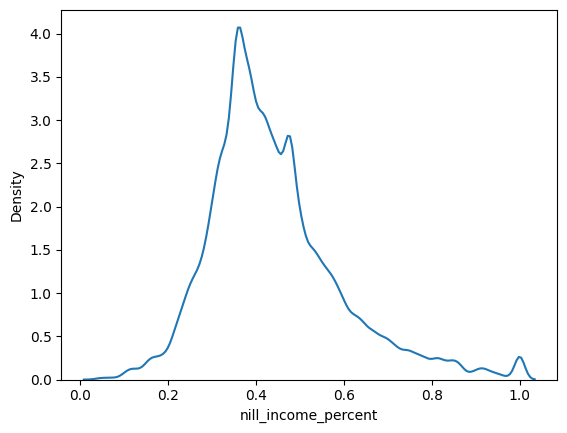

In [78]:
sns.kdeplot(census_consumers["nill_income_percent"])

In [93]:
customer_qualities = transactions.merge(merchants, on="merchant_abn")[["merchant_abn", "user_id"]].merge(census_consumers).drop(["user_id", "postcode"], axis=1)
merchant_customer_qualities = customer_qualities.groupby("merchant_abn").mean().reset_index()

In [94]:
merchant_customer_qualities["customer_quality"] = 0.1 * (1 - merchant_customer_qualities["nill_income_percent"]) + 0.25 * (1 - merchant_customer_qualities["house_repay_to_income"]) + 0.4 * merchant_customer_qualities["age_factor"] + 0.35 * (1 - merchant_customer_qualities["high_income_proportion"])

In [95]:
customer_qualities["customer_quality"] = 0.1 * (1 - customer_qualities["nill_income_percent"]) + 0.25 * (1 - customer_qualities["house_repay_to_income"]) + 0.4 * customer_qualities["age_factor"] + 0.35 * (1 - customer_qualities["high_income_proportion"])

<AxesSubplot:xlabel='customer_quality', ylabel='Density'>

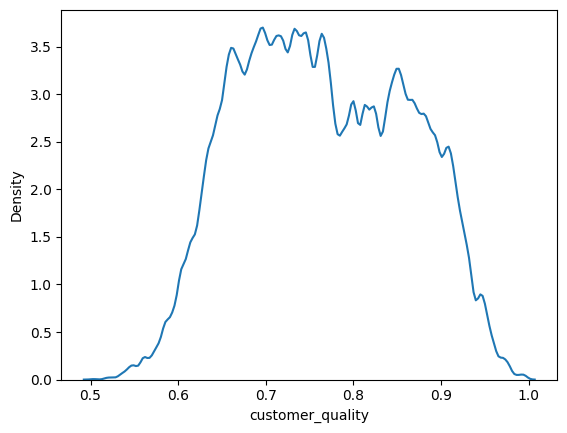

In [96]:
sns.kdeplot(customer_qualities["customer_quality"])

In [44]:
merchant_customer_qualities.sort_values("customer_quality", ascending=True)


,merchant_abn,house_repay_to_income,high_income_proportion,nill_income_percent,age_factor,customer_quality
1700,47047735645,0.335161,0.102906,0.850323,0.097938,0.534336
3362,84787662573,0.203390,0.063854,0.816044,0.175939,0.615575
3114,79081516258,0.209953,0.096745,0.649920,0.196414,0.627224
233,15293888435,0.234872,0.087257,0.639062,0.212754,0.631938
889,29279482521,0.215783,0.113313,0.402561,0.217890,0.653294
...,...,...,...,...,...,...
2563,67213521157,0.254922,0.053112,0.311632,0.826440,0.917093
1845,50532670634,0.218425,0.030726,0.459770,0.827295,0.919580
2053,55403018592,0.204862,0.054423,0.424899,0.861816,0.931973
3437,86621434137,0.333585,0.041427,0.255887,0.891636,0.933170


In [ ]:
# len(df)

My sad attempts at trying to fix the model below

In [ ]:




# def train(df, census_consumers, merchants):
#     ENCODED_COLS = ["gender", "sector_tags", "revenue_band"]
#     SCALED_COLS = ["yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "take_rate"]
#     model = SGDRegressor()
#     encoder = OneHotEncoder()
#     scaler = StandardScaler()
#     i = 0
#     df = df.sample(frac=1)
#     interval = int(1e5)
#     test_size = int(1e5)
#     while i < len(df):
#         print(f"Training Sample: {i}-{min(i+interval, len(df)-test_size)}")
#         df_merged = df[i:min(i+interval, len(df)-test_size)].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#         i += interval
#         X, y = get_features_and_labels(df_merged, encoder, scaler, ENCODED_COLS, SCALED_COLS)
#         model.partial_fit(X, y)
#     test_df = df[-test_size:].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#     print(f"Test Score: {model.score(*get_features_and_labels(test_df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=False))}")

# def get_features_and_labels(df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=True):
#         X = df[["gender", "yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "sector_tags", "revenue_band", "take_rate"]]
#         X["take_rate"] = pd.to_numeric(X["take_rate"])
#         X["house_repay_to_income"] = pd.to_numeric(X["house_repay_to_income"])
#         scaled_columns =  scaler.fit_transform(X[SCALED_COLS]) if train else scaler.transform(X[SCALED_COLS])
#         encoded_columns =  encoder.fit_transform(X[ENCODED_COLS]) if train else encoder.transform(X[ENCODED_COLS])
#         X = np.concatenate([scaled_columns, encoded_columns], axis=1)
#         y = df["dollar_value"]
#         return X, y





In [ ]:
# train(df, census_consumers, merchants)

In [ ]:
# df_merged.count()

In [ ]:
# len(X)

In [ ]:
# X = X.to_pandas()

In [ ]:
# y = y.to_pandas()

In [ ]:
# type(X)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
# model = ElasticNet()
# model.fit(X_train, y_train)

In [48]:
ranking.dtypes

index                       int64
merchant_abn                int64
name                       object
tags                       object
sector_tags                object
revenue_band               object
take_rate                  object
retention                 float64
volume_mean               float64
volume_stdev              float64
amount_mean               float64
amount_stdev              float64
month                       int64
monthly_revenue           float64
6-month-sma               float64
6-month-sma-shifted       float64
12-month-sma              float64
12-month-sma-shifted      float64
6-month-sma-diff          float64
12-month-sma-diff         float64
house_repay_to_income     float64
high_income_proportion    float64
nill_income_percent       float64
age_factor                float64
customer_quality          float64
dtype: object

In [147]:

ranking = retention.reset_index().merge(counts).merge(revenue_and_momentum).merge(merchant_customer_qualities, on="merchant_abn").fillna(0)
ranking = ranking[["merchant_abn", "name", "retention", "revenue_score", "momentum_score", "customer_quality", "sector_tags"]]
ranking["score"] = 0.6 * ranking["revenue_score"] + 0.15 * ranking["momentum_score"] + 0.15 * ranking["retention"] + 0.1 * ranking["customer_quality"]
ranking.sort_values("score", ascending=False).round(2).reset_index().to_csv("lol.csv")

# ranking.sort_values("score", ascending=False)



<AxesSubplot:xlabel='customer_quality', ylabel='Density'>

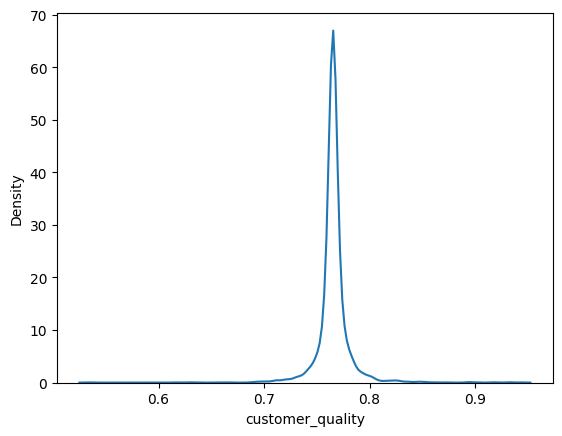

In [98]:
sns.kdeplot(merchant_customer_qualities["customer_quality"])

In [134]:
merchant_postcodes = merchants.merge(transactions, on="merchant_abn").merge(consumers, on="user_id").groupby(["merchant_abn", "postcode"]).count().reset_index().sort_values("dollar_value").groupby("merchant_abn").last().reset_index()

In [138]:
merchant_postcodes.sort_values("dollar_value", ascending=False)

,merchant_abn,postcode,name_x,tags,sector_tags,revenue_band,take_rate,user_id,dollar_value,order_id,order_datetime,month,consumer_id,name_y,address,state,gender
679,24852446429,6470,228,228,228,228,228,228,228,228,228,228,228,228,228,228,228
3437,86578477987,7320,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216
2434,64203420245,1819,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204
1823,49891706470,3415,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204
1690,46804135891,1819,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,30203637111,6987,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
930,30137717102,2093,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2969,75726900852,4205,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
924,29922107583,4882,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [141]:
merchants = merchants.reset_index()
merchant_postcodeee = merchants.merge(transactions, on="merchant_abn").merge(consumers, on="user_id").groupby(["merchant_abn", "postcode"]).count().reset_index()


,merchant_abn,postcode,name_x,tags,sector_tags,revenue_band,take_rate,user_id,dollar_value,order_id,order_datetime,month,consumer_id,name_y,address,state,gender
574078,24852446429,200,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
574079,24852446429,800,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138
574080,24852446429,801,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79
574081,24852446429,804,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
574082,24852446429,810,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577238,24852446429,9013,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93
577239,24852446429,9015,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
577240,24852446429,9464,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125
577241,24852446429,9726,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64


<AxesSubplot:xlabel='name_x', ylabel='Density'>

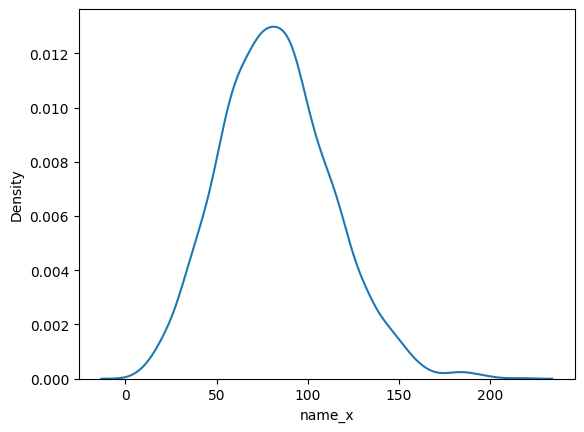

In [146]:
sns.kdeplot(merchant_postcodeee[merchant_postcodeee["merchant_abn"] == 86578477987]["name_x"])

This indicates that the customer generation algorithm samples randomly from suburbs (or at least does not rely on any correlated variables to our engineered features to choose which customers decide to shop where). Whereas we found our customer quality to be an excellent metric at differentiating high and low value customers, it does not seem to provide much of a differentiating factor in our final model.

In [102]:
for grouping in set(merchant_groupings.values()):
    print(grouping)
    tags_list = [i for i in merchant_groupings.keys() if merchant_groupings[    i] == grouping]
    display(ranking[ranking["sector_tags"].isin(tags_list)].sort_values("score", ascending=False).head())

Business Services


,merchant_abn,name,retention,revenue_score,momentum_score,customer_quality,sector_tags,score
46,35909341340,Arcu Sed Eu Incorporated,0.377500,0.708582,0.524696,0.766196,"computer programming , data processing, and in...",0.637098
86,58454491168,Diam At Foundation,0.279798,0.617034,0.495935,0.764912,"computer programming , data processing, and in...",0.563071
45,67400260923,Eleifend PC,0.381212,0.502232,0.515774,0.765394,"computer programming , data processing, and in...",0.512426
89,77590625261,Sed Diam Foundation,0.272368,0.387516,0.533965,0.765125,"computer programming , data processing, and in...",0.429972
78,94455880010,Nunc Sit LLC,0.287177,0.231515,0.510398,0.766465,"computer programming , data processing, and in...",0.335192


Miscellaneous Stores


,merchant_abn,name,retention,revenue_score,momentum_score,customer_quality,sector_tags,score
1,86578477987,Leo In Consulting,0.969028,0.952110,0.520289,0.765376,"watch, clock, and jewelry repair shops",0.871201
17,32361057556,Orci In Consequat Corporation,0.664392,1.000000,0.529729,0.765256,"gift, card, novelty, and souvenir shops",0.855644
12,64403598239,Lobortis Ultrices Company,0.773248,0.965683,0.526096,0.765415,"music shops - musical instruments, pianos, and...",0.850853
6,89726005175,Est Nunc Consulting,0.937524,0.861313,0.528928,0.765146,tent and awning shops,0.813270
5,45629217853,Lacus Consulting,0.941055,0.819798,0.518982,0.765274,"gift, card, novelty, and souvenir shops",0.787412


Utility services


,merchant_abn,name,retention,revenue_score,momentum_score,customer_quality,sector_tags,score
11,21439773999,Mauris Non Institute,0.780963,0.894282,0.524244,0.765447,"cable, satellite, and other pay television and...",0.808895
545,82368304209,Nec Incorporated,0.060253,0.700684,0.559979,0.766023,telecom,0.590048
54,17488304283,Posuere Cubilia Curae Corporation,0.353629,0.326002,0.519456,0.766513,"cable, satellite, and other pay television and...",0.403215
1100,93260930990,Pede Cras Vulputate Ltd,0.022406,0.375875,0.499716,0.762284,telecom,0.380072
98,94472466107,Eu Dolor Egestas PC,0.255019,0.131674,0.511583,0.765459,"cable, satellite, and other pay television and...",0.270541


Professional services and membership organisations


,merchant_abn,name,retention,revenue_score,momentum_score,customer_quality,sector_tags,score
24,48534649627,Dignissim Maecenas Foundation,0.560206,0.858046,0.528986,0.764774,"opticians, optical goods, and eyeglasses",0.754684
4,46804135891,Suspendisse Dui Corporation,0.944943,0.288396,0.520314,0.765434,"opticians, optical goods, and eyeglasses",0.469369
258,95574756848,At Pede Inc.,0.133073,0.373195,0.517497,0.765766,"opticians, optical goods, and eyeglasses",0.398079
327,92065881715,Quam Elementum Corp.,0.107265,0.190654,0.528854,0.766314,"opticians, optical goods, and eyeglasses",0.286441
118,11237511112,Magna Institute,0.225500,0.137054,0.526656,0.764600,"opticians, optical goods, and eyeglasses",0.271516


Retail outlet services


,merchant_abn,name,retention,revenue_score,momentum_score,customer_quality,sector_tags,score
61,96680767841,Ornare Limited,0.328149,0.897430,0.516293,0.765408,motor vehicle supplies and new parts,0.741665
7,43186523025,Lorem Ipsum Sodales Industries,0.922267,0.650190,0.520659,0.765385,"florists supplies, nursery stock, and flowers",0.683091
158,45433476494,Adipiscing Elit Foundation,0.187506,0.685691,0.514582,0.765411,"computers, computer peripheral equipment, and ...",0.593269
0,24852446429,Erat Vitae LLP,0.974489,0.398765,0.521725,0.765239,"florists supplies, nursery stock, and flowers",0.540215
49,49212265466,Auctor Company,0.366647,0.538097,0.518074,0.764206,"florists supplies, nursery stock, and flowers",0.531987
